# Population structure

With the advent of SNP data it is possible to precisely infer the genetic distance across individuals or populations. As written in the book, one way of doing it is by comparing each SNP from each individual against every other individual. This comparison produces the so called: covariance matrix, which in genetic terms means the number of shared polymorphisms across individuals.
There are many ways to visualize this data, in this tutorial you will be exposed to `Principal Component Analysis` and `Admixture` software.

We will use the R package `SNPRelate`, which can easily handle vcf files and do the PCA. If you want to explore a bit more on the functionality of the package access [here](https://www.rdocumentation.org/packages/SNPRelate/versions/1.6.4).

## How to make this notebook work

* In this notebook we will use both the `command line bash` commands and `R` to setup the file folders.
* Having to shift between two languages, you need to choose a kernel every time we shift from one language to another. A kernel contains a programming language and the necessary packages to run the course material. To choose a kernel, go on the menu on the top of the page and select `Kernel --> Change Kernel`, and then select the preferred one. We will shift between two kernels, and along the code in this notebook you will see a picture telling you to change kernel. The two pictures are below:

<img src="img/bash.png" alt="Bash" width="80"> Shift to the `Bash` kernel

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

* You can run the code in each cell by clicking on the run cell sign in the toolbar, or simply by pressing <kbd>Shift</kbd>+<kbd>Enter</kbd>. When the code is done running, a small green check sign will appear on the left side.
* You need to run the cells in sequential order to execute the analysis. Please do not run a cell until the one above is done running, and do not skip any cells
* The code goes along with textual descriptions to help you understand what happens. Please try not to focus on understanding the code itself in too much detail - but rather try to focus on the explanations and on the output of the commands 
*   You can create new code cells by pressing `+` in the Menu bar above or by pressing <kbd>B</kbd> after you select a cell. 


## Learning outcomes

At the end of this tutorial you will be able to

- **Extract** information from a `vcf` file and create a PCA projection
- **Apply** LD pruning to reveal population structure

## Setting up folders

Here we setup a link to the `Data` folder and creagte the `Results` folder.

<img src="img/bash.png" alt="Bash" width="80"> Choose the `Bash` kernel

In [4]:
ln -s ../../Data
mkdir -p Results

In [6]:
gunzip -ck Data/vcf/Allvariants_135_145_chr2.vcf.gz > Results/Allvariants_135_145_chr2.vcf

# PCA from VCF data file

<img src="img/R.png" alt="R" width="80"> Shift to the `popgen course` kernel

In [1]:
library(SNPRelate)
library(ggplot2)

Loading required package: gdsfmt

SNPRelate -- supported by Streaming SIMD Extensions 2 (SSE2)



## Import data and calculate PCA

We read the metadata about the samples (geographic locations) and transform the `vcf` file into `gds` format, from which the package `SNPRelate` can calculate the PCA projection of the data.

In [2]:
# Reading the metadata information 
info = read.csv("Data/metadata/sample_infos_accessionnb.csv", header = T, sep = ';')

# Setting the directory of the VCF file 
vcf.fn <- "Results/Allvariants_135_145_chr2.vcf"

# Transforming the vcf file to gds format
snpgdsVCF2GDS(vcf.fn, "Results/Allvariants_135_145_chr2_2.gds", method="biallelic.only")

#Read the file and calculate the PCA
genofile <- snpgdsOpen("Results/Allvariants_135_145_chr2_2.gds",  FALSE, TRUE, TRUE)
pca <- snpgdsPCA(genofile)
summary(pca)

Start file conversion from VCF to SNP GDS ...
Method: extracting biallelic SNPs
Number of samples: 27
Parsing "Results/Allvariants_135_145_chr2.vcf" ...
	import 49868 variants.
+ genotype   { Bit2 27x49868, 328.7K } *
Optimize the access efficiency ...
Clean up the fragments of GDS file:
    open the file 'Results/Allvariants_135_145_chr2_2.gds' (519.6K)
    # of fragments: 50
    save to 'Results/Allvariants_135_145_chr2_2.gds.tmp'
    rename 'Results/Allvariants_135_145_chr2_2.gds.tmp' (519.3K, reduced: 360B)
    # of fragments: 20
Principal Component Analysis (PCA) on genotypes:
Excluding 0 SNP on non-autosomes
Excluding 397 SNPs (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 27
    # of SNPs: 49,471
    using 1 thread
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 2250084
CPU capabilities: Double-Precision SSE2
Thu Jan  5 14:38:36 2023    (internal increment: 101792)
[==================================================] 100%

          Length Class  Mode     
sample.id    27  -none- character
snp.id    49471  -none- numeric  
eigenval     27  -none- numeric  
eigenvect   729  -none- numeric  
varprop      27  -none- numeric  
TraceXTX      1  -none- numeric  
Bayesian      1  -none- logical  
genmat        0  -none- NULL     

**Q.1** How many individuals and snps does this dataset have? What is an eigenvector and an eigenvalue?

The `pca` object just created is a list containing various elements.

In [4]:
ls(pca)

[1] "Bayesian"  "eigenval"  "eigenvect" "genmat"    "sample.id" "snp.id"   
[7] "TraceXTX"  "varprop"

We use `pca$eigenvect` to plot the PCA. We extract also `pca$sample.id` to match the geographic locations in the metadata with the samples in `pca`.

In [14]:
eigenvectors = as.data.frame(pca$eigenvect[,1:5])
colnames(eigenvectors) = as.vector(sprintf("PC%s", seq(1:ncol(eigenvectors))))
pca$sample.id = sub("_chr2_piece_dedup", "", pca$sample.id)

# Matching the sample names with their origin and population
rownames(info) <- info[,"ENA.RUN"]
eigenvectors <- cbind(eigenvectors, info[pca$sample.id, c("population","region")])


In the end, we have created a table called `eigenvectors` containing the PCA coordinates and some metadata

In [17]:
head(eigenvectors)

,PC1,PC2,PC3,PC4,PC5,region,population
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,-0.08797594,-0.09112105,-0.018765738,-0.009707983,-0.034487827,EastAsia,Naxi
2,-0.08922936,-0.12111275,-0.069492271,-0.002468963,-0.053851009,EastAsia,Miao
3,-0.07715339,-0.08393755,-0.031730341,-0.005722997,-0.057211803,EastAsia,Japanese
4,0.63590783,-0.18486541,0.026214440,-0.056798669,0.051522054,Africa,Ju_hoan_North
5,0.66123851,-0.21762437,0.003079055,0.069235635,0.005858126,Africa,Ju_hoan_North
6,-0.08093083,-0.10223892,-0.023168510,-0.021349088,-0.059966252,EastAsia,Atayal


Let's first look at how much of the variance of the data is explained by each eigenvector:

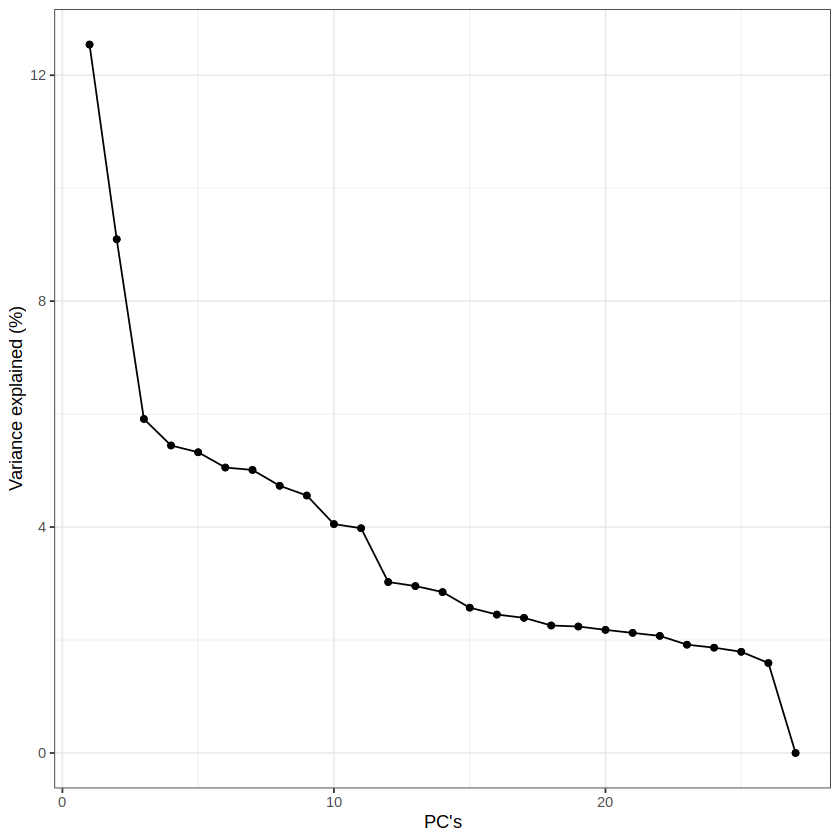

In [18]:
# Variance proportion:
pca_percent <- pca$varprop*100
qplot(y = pca_percent, x = seq(1, length(pca$eigenval))) + geom_line() + geom_point() + theme_bw() + xlab("PC's") + ylab("Variance explained (%)") 

**Q.2** How many PC's do we need in order to explain 50% of the variance of the data? Can you make an accumulative plot of the variance explained PC?

## Visualization

We plot now the first two PCA coordinates and label them by Population, with color by region. We can see how only africans are separated from the rest, but the PCA is quite confused and cannot distinguish EastAsia and WestEurasia.

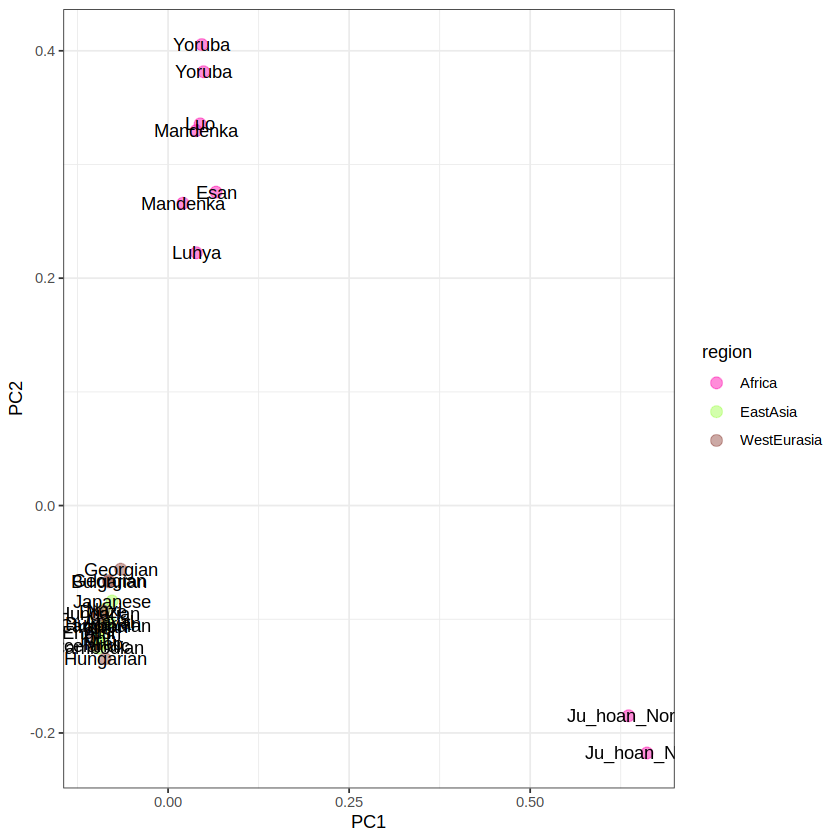

In [14]:
ggplot(data = eigenvectors, aes(x = PC1, y = PC2, col = region)) + 
        geom_point(size=3,alpha=0.5) + geom_text( aes(label=population), col="black") +
        scale_color_manual(values = c("#FF1BB3","#A7FF5B","#99554D")) +
        theme_bw()

**Q.2** Try to plot PC2 and PC3. Do you see the same patterns? What is the correlation between PC2 and PC3 (hint use the function cor())?

**Q.3** Try also to color the graph based on population. What do you observe?

## LD pruning

We implement LD pruning to eliminate those SNPs that are in high linkage disequilibrium, so that we avoid highly correlated SNPs that would alter our PCA. We end up keeping a handful of SNPs, but the population structure is now much more clear.

SNP pruning based on LD:
Excluding 0 SNP on non-autosomes
Excluding 397 SNPs (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 27
    # of SNPs: 49,471
    using 1 thread
    sliding window: 500,000 basepairs, Inf SNPs
    |LD| threshold: 0.3
    method: composite
Chromosome 2: 1.22%, 607/49,868
607 markers are selected in total.
Principal Component Analysis (PCA) on genotypes:
Excluding 49,261 SNPs (non-autosomes or non-selection)
Excluding 0 SNP (monomorphic: TRUE, MAF: NaN, missing rate: NaN)
    # of samples: 27
    # of SNPs: 607
    using 2 threads
    # of principal components: 32
PCA:    the sum of all selected genotypes (0,1,2) = 29826
CPU capabilities: Double-Precision SSE2
Thu Jan  5 14:58:35 2023    (internal increment: 101792)
[==================================================] 100%, completed, 0s  
Thu Jan  5 14:58:35 2023    Begin (eigenvalues and eigenvectors)
Thu Jan  5 14:58:35 2023    Done.


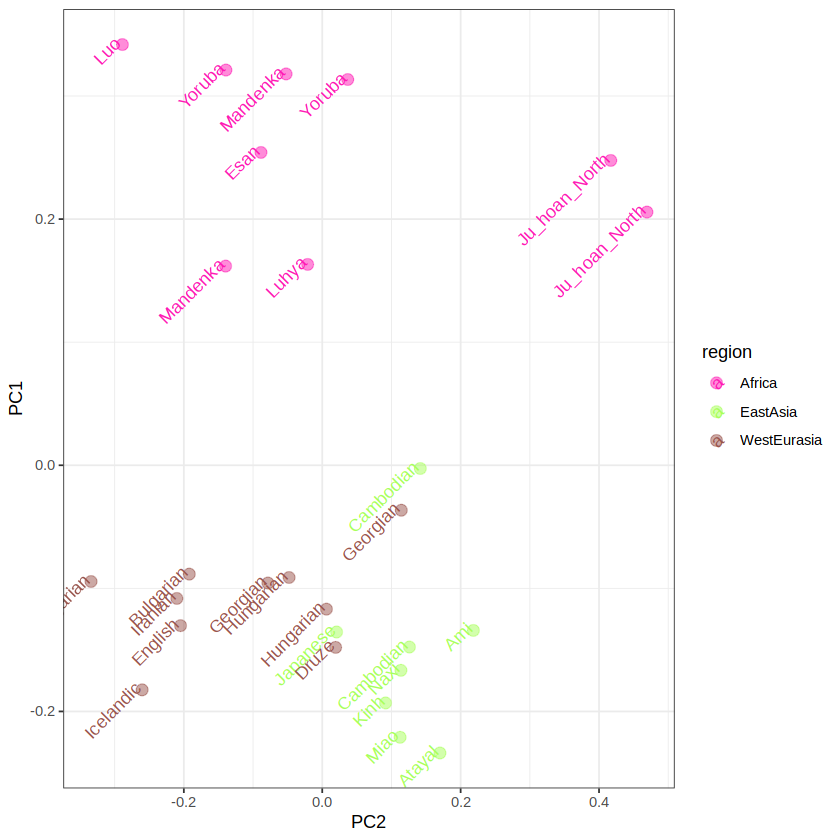

In [28]:
set.seed(1000)

# This function prune the snps with a thrshold of maximum 0.3 of LD
snpset <- snpgdsLDpruning(genofile, ld.threshold=0.3)

# Get all selected snp's ids
snpset.id <- unlist(snpset)

pca_pruned <- snpgdsPCA(genofile, snp.id=snpset.id, num.thread=2)

#add metadata
eigenvectors = as.data.frame(pca_pruned$eigenvect)
colnames(eigenvectors) = as.vector(sprintf("PC%s", seq(1:nrow(pca$eigenvect))))
pca_pruned$sample.id = sub("_chr2_piece_dedup", "", pca$sample.id)
eigenvectors <- cbind(eigenvectors, info[pca$sample.id, c("population","region")])

#plot
ggplot(data = eigenvectors, aes(x = PC1, y = PC2, col = region, label=population)) + 
        geom_text(hjust=1, vjust=0, angle=45) +
        geom_point(size=3,alpha=0.5) +
        scale_color_manual(values = c("#FF1BB3","#A7FF5B","#99554D")) +
        theme_bw() + coord_flip()